### Import libraries

In [1]:
import IPython.display as ipd
import librosa
import matplotlib.pyplot as plt
import numpy as np

from utils.plot_waveform import plot_waveform
from utils.read_audio_and_plot import read_audio_and_plot
from utils.record_audio_and_plot import record_audio_and_plot
from utils.save_and_play_signal import save_and_play_signal

### What is audio?

Sine Waves:
A common way to represent a signal is as a sine wave, which can be expressed as: 
$$
s(t) = A \cdot \sin(2\pi f t + \phi)
$$
Where:

- `A` is the amplitude, representing the signal's strength.
- `f` is the frequency, representing how often the wave repeats.
- `t` is time.
- `φ` is the phase, representing the wave's starting point.

Additional source: [An Introduction to Electronics](https://www.open.edu/openlearn/science-maths-technology/an-introduction-electronics/content-section-4.4)

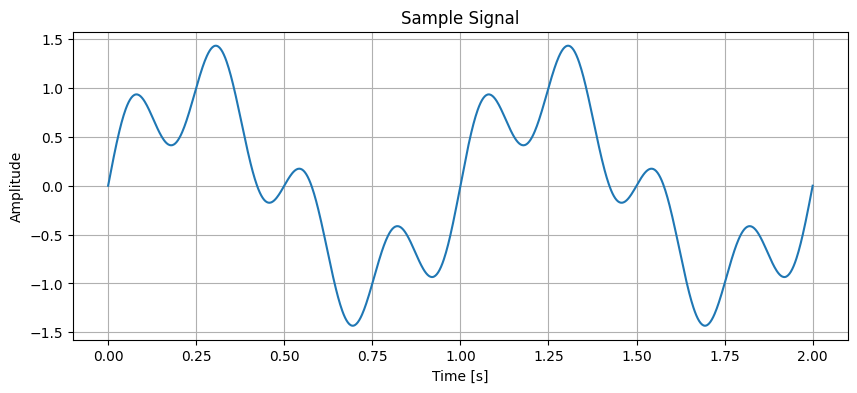

In [2]:
# sample audio signal made up of sine and cosine waves
sample_freq1 = 1
sample_freq2 = 4
t = np.linspace(0, 2, 1000)
signal = \
    1 * np.sin(2 * np.pi * sample_freq1 * t) \
    + 0.5 * np.sin(2 * np.pi * sample_freq2 * t)

# Plot the signal
plt.figure(figsize=(10, 4))
plt.plot(t, signal)
plt.title("Sample Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

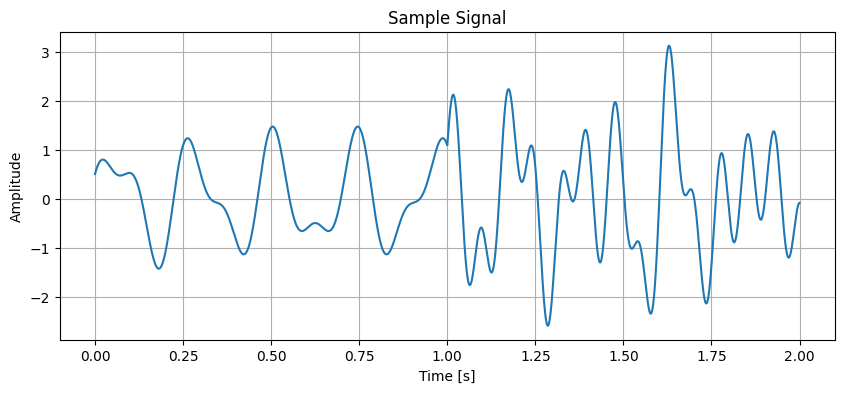

In [3]:
# Your signal
sample_freq1 = 4.40 #Hz
sample_freq2 = 8.00
t = np.linspace(0, 2, 44000) # duration t seconds
signal = np.sin(2 * np.pi * sample_freq1 * t) \
    + 0.5 * np.cos(2 * np.pi * sample_freq2 * t)

# Add more sine waves starting half way
freq3 = 6.60 # E5 note
freq4 = 13.20 # E6 note
halfway = len(t) // 2

signal2 = signal.copy()
signal2[halfway:] += np.sin(2*np.pi*freq3*t[:len(t)-halfway])
signal2[halfway:] += np.sin(2*np.pi*freq4*t[:len(t)-halfway])

final_signal = signal2.copy()

# save_and_play_signal(signal=final_signal, duration=2)

plot_waveform(t, final_signal)

In [4]:
# Frequencies
sample_freq1 = 65
sample_freq2 = 265

# Parameters
duration = 2
sr_temp = 44000
halfway = sr_temp // 2

# Time arrays for each half
t1 = np.linspace(0, 1, halfway, endpoint=False)
t2 = np.linspace(0, 1, halfway, endpoint=False)

# First half: sample_freq1
first_half = 1 * np.sin(2 * np.pi * sample_freq1 * t1)

# Second half: sample_freq2
second_half = 1 * np.sin(2 * np.pi * sample_freq2 * t2)

# Combine the halves
final_signal = np.concatenate([first_half, second_half])

# Create and play audio
save_and_play_signal(signal=final_signal, duration=duration)

### Generate audio

#### Manual Sine Wave Generation

In [5]:
sr = 3000  # Sample rate
T = 2.0    # seconds
t = np.linspace(0, T, int(sr*T), endpoint=False)

In [6]:
# First two sine waves
freq1 = 440    # A4 note
freq2 = 880    # A5 note
signal = np.sin(2*np.pi*freq1*t) + np.sin(2*np.pi*freq2*t)

In [7]:
# # Add more sine waves starting half way
freq3 = 660   # E5 note
freq4 = 1320  # E6 note
halfway = len(t) // 2

signal2 = signal.copy()
# signal2[halfway:] += np.sin(2*np.pi*freq3*t[:len(t)-halfway])
# signal2[halfway:] += np.sin(2*np.pi*freq4*t[:len(t)-halfway])

In [8]:
final_signal = signal2.copy()

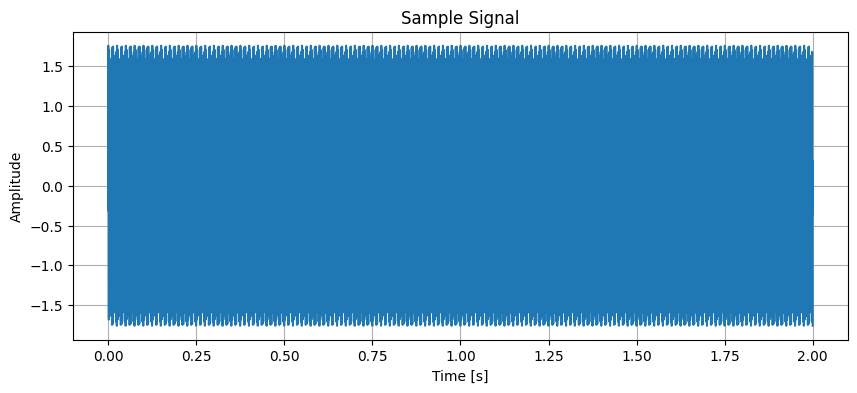

In [9]:
plot_waveform(t, final_signal)

### Fast Fourier Transform (FFT)

#### Who is Fourier?

<img src="./images/Fourier.jpg" alt="Fourier" style="width:300px; height:auto;">
<!-- Source: https://en.wikipedia.org/wiki/Joseph_Fourier -->

#### FFT example

$$
X(f) = \int_{-\infty}^{\infty} x(t) e^{-j 2 \pi f t} \, dt
$$

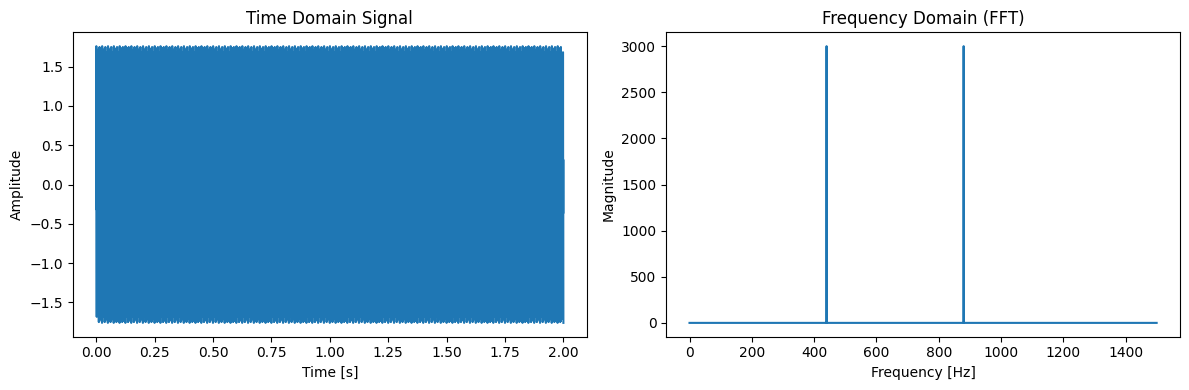

In [10]:
# FFT
fft_vals = np.fft.fft(final_signal)
fft_freqs = np.fft.fftfreq(len(fft_vals), 1/sr)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(np.linspace(0, len(final_signal) / sr, len(final_signal)), final_signal)
plt.title("Time Domain Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

plt.subplot(1, 2, 2)
plt.plot(fft_freqs[:len(fft_freqs)//2], np.abs(fft_vals)[:len(fft_vals)//2])
plt.title("Frequency Domain (FFT)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.tight_layout()
plt.show()

### Short-Time Fourier Transform (STFT)

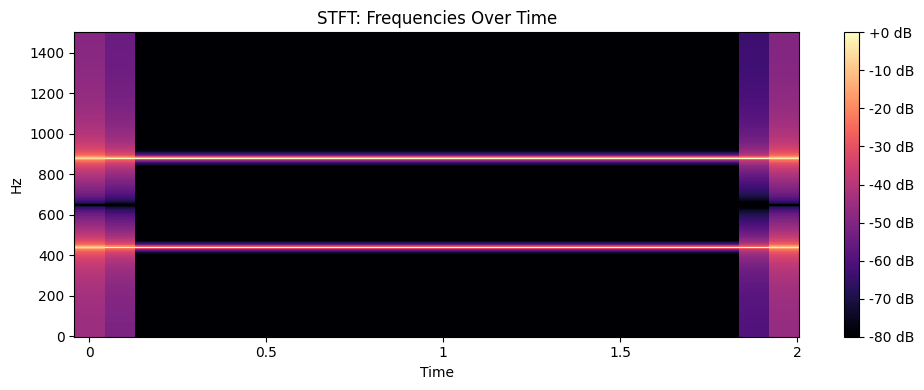

In [11]:
n_fft = 1024
hop_length = 256
stft_matrix = librosa.stft(final_signal, n_fft=n_fft, hop_length=hop_length)
stft_db = librosa.amplitude_to_db(np.abs(stft_matrix), ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(stft_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title("STFT: Frequencies Over Time")
plt.tight_layout()
plt.show()

### Mel Frequency Cepstral Coefficients (MFCC)

#### What makes us sensitive to lower frequencies?

<img src="./images/Ear_Anatomy.jpg" alt="Ear Anatomy" style="width: 600px;"/>
<!-- Source: https://www.nidcd.nih.gov/health/how-do-we-hear -->

<img src="./images/MelScale.png" alt="Ear Anatomy" style="width: 1000px;"/>

In [12]:
# Examples of perceived difference in pitch in 
# lower frequencies vs higher frequencies

# play C2_C4.wav # 65 260 200
sample_audio_file = "./audiofiles/notes/C2_C4.wav"

# play G6_A6.wav 1560 1760 200
# sample_audio_file = "./audiofiles/notes/G6_A6.wav"

ipd.Audio(sample_audio_file)

#### Understanding process of getting MFCC

Procedure for getting MFCCs.
- FFT
- Mel Filterbank (highlighted with <span style="color:red">red</span> question mark)
- Logarithm
- Discreet Cosine Transform [DCT]

<img src="./images/OverallMFCCProcess.png" alt="Ear Anatomy" style="width: 800px;"/>

<img src="./images/FilterBank.png" alt="Ear Anatomy" style="width: 1000px;"/>

<img src="./images/AppliedTriangularFilterBank.png" alt="Ear Anatomy" style="width: 800px;"/>

<img src="./images/MFCCSummary.png" alt="Ear Anatomy" style="width: 1000px;"/>

#### MFCC example

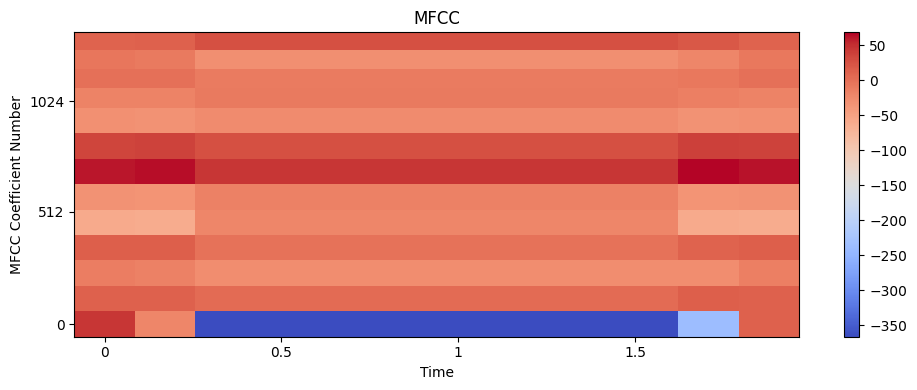

In [13]:
n_mfcc = 13
mfccs = librosa.feature.mfcc(
    y=final_signal, sr=sr, n_mfcc=n_mfcc, n_fft=2048, hop_length=512
)

# Create the plot with the new y-axis label
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar()
plt.title("MFCC")
plt.xlabel("Time")
plt.ylabel("MFCC Coefficient Number")
plt.tight_layout()
plt.show()

In [14]:
len(mfccs)

13

In [15]:
len(mfccs[0])

12

In [16]:
np.mean(mfccs, axis=1)

array([-260.7715629 ,    7.61081491,  -24.56789084,    2.86108311,
        -34.42207904,  -21.98724087,   51.94525625,   30.5362172 ,
        -27.93626122,  -10.90985131,   -7.98329847,  -22.43533939,
         22.56979363])

#### MFCC Shape Calculation

The total number of samples is given by:

$$
N = sr \times T
$$

Where:
- \( sr \) is the sample rate (samples per second)
- \( T \) is the duration of the audio in seconds

The number of frames can be calculated as:

$$
n\_frames = 1 + \left\lfloor \frac{N}{\text{hop\_length}} \right\rfloor
$$

Where:
- ( hop\_length \) is the number of samples between successive frames

MFCC shape: (n\_mfcc, n\_frames)

### Sample audio recording and plots

Loading audio file: ./audiofiles/notes/C2_C4.wav at 22050 Hz...
Audio player (notebooks will show a widget)...


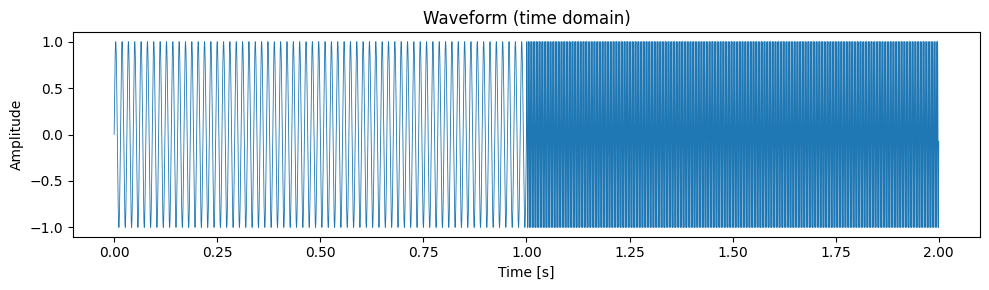

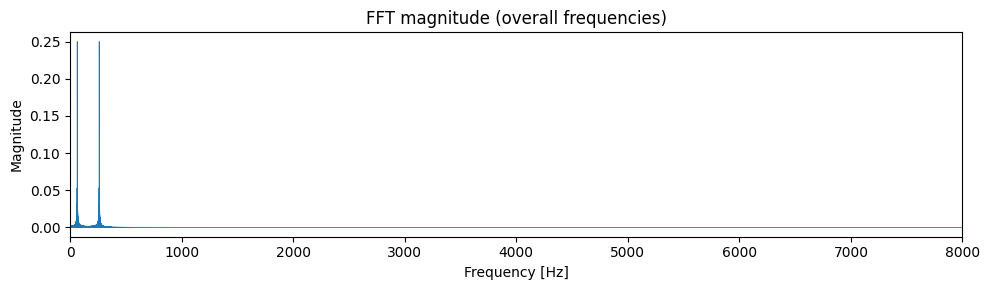

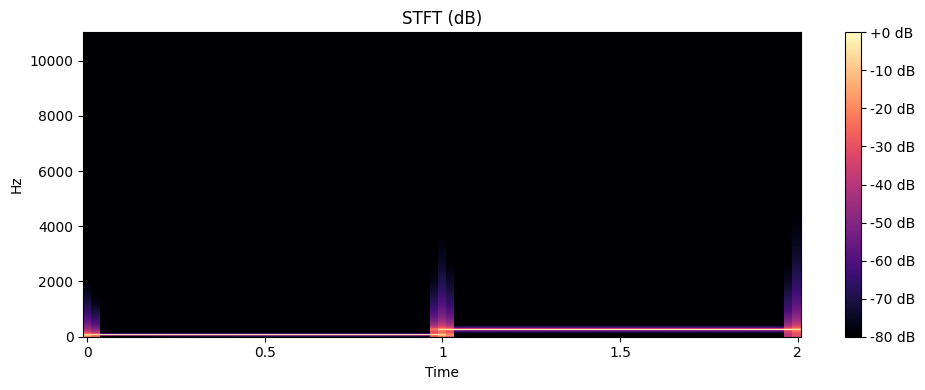

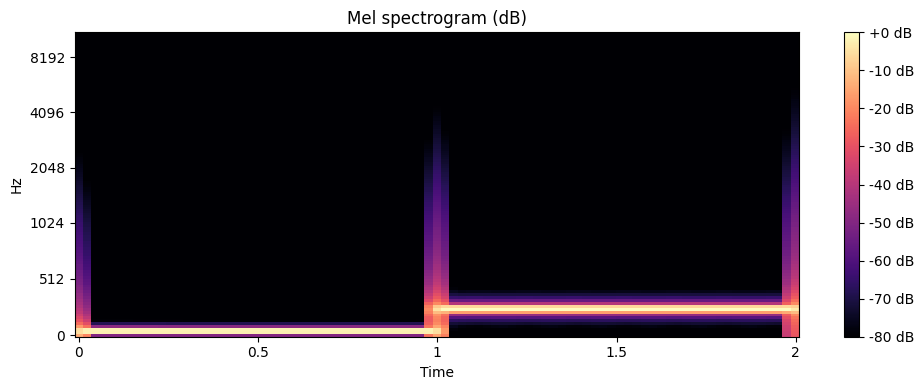

MFCC shape: (13, 87)


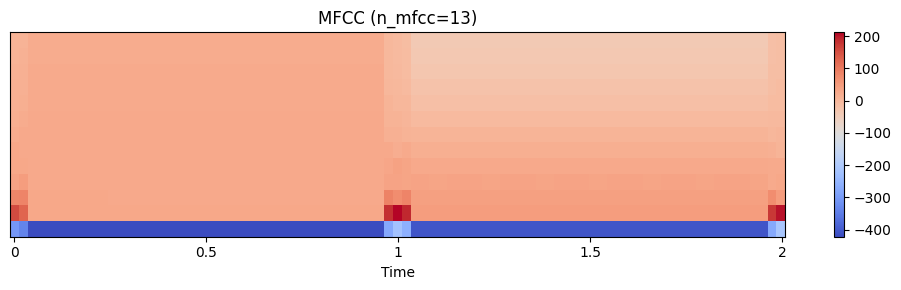

Done. You can re-run with different sr / n_fft / hop_length to see how things change.


In [17]:
read_audio_and_plot(
    filepath="./audiofiles/notes/C2_C4.wav",
)

Recording 4 seconds at 22050 Hz...
Audio player (notebooks will show a widget)...


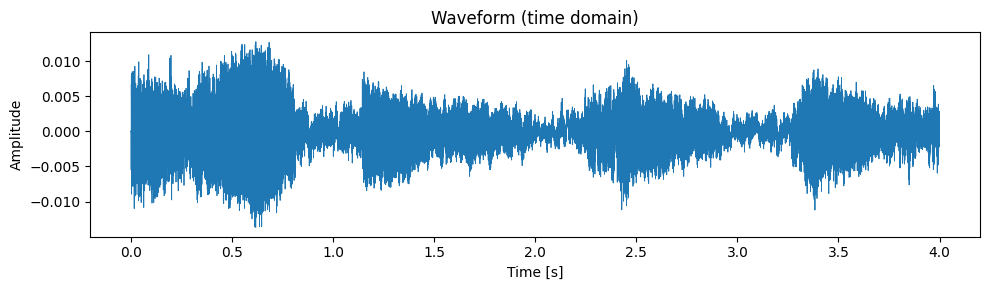

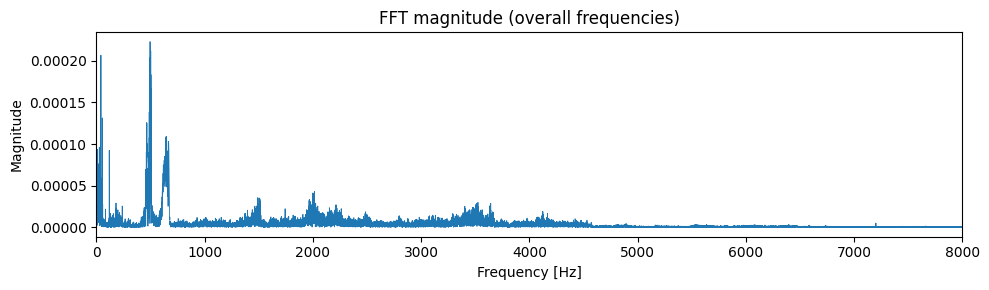

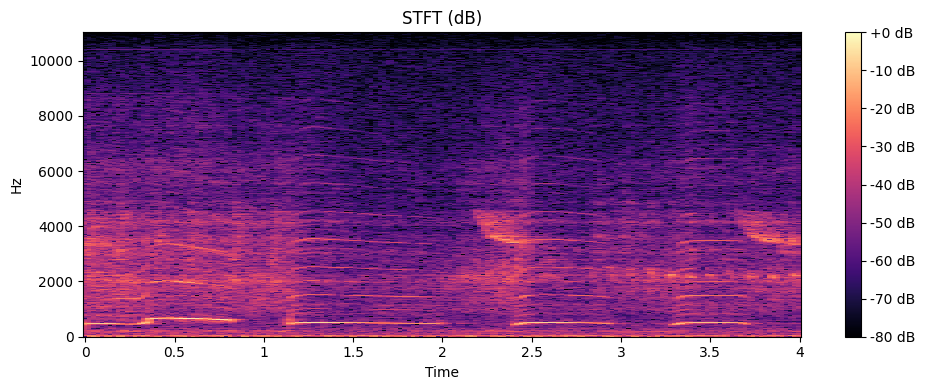

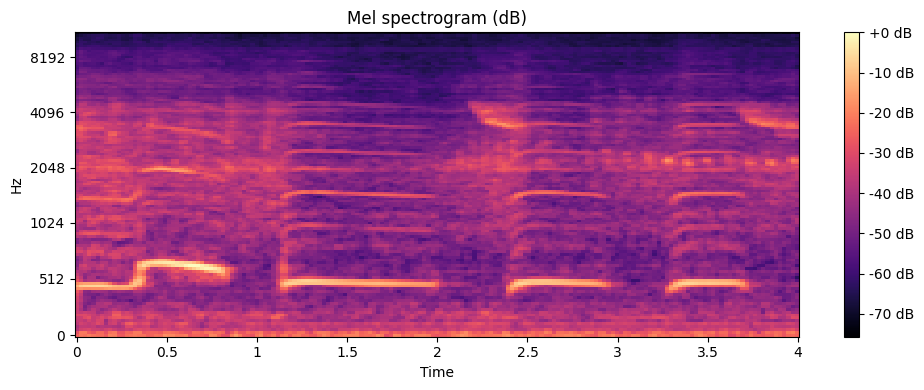

MFCC shape: (13, 173)


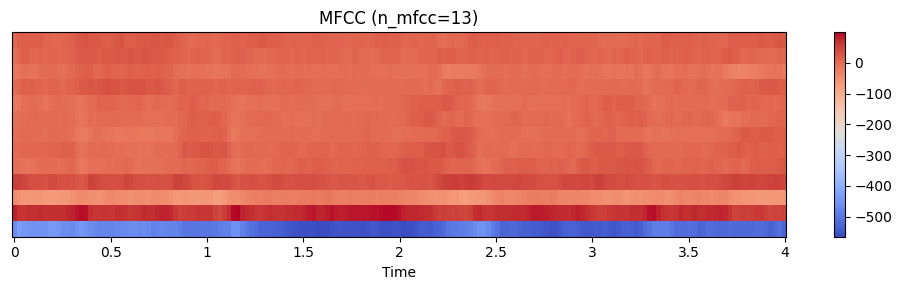

Done. You can re-run with different sr / n_fft / hop_length / duration to see how things change.


In [18]:
record_audio_and_plot(
    duration=4
)

### Resources

This section contains links to various resources related to audio processing, including libraries, tutorials, and research papers.

- Libraries
  - [Librosa](https://librosa.org/): A Python library for analyzing and processing audio signals.
  - [SoundFile](https://pypi.org/project/soundfile/): A library for reading and writing sound files.
- Tutorials
  - [Mel-Spectrogram and MFCCs | Lecture 72 (Part 1) | Applied Deep Learning](https://youtu.be/hF72sY70_IQ?si=u7XEST_Js1mL13a4)
  - [Mel Frequency Cepstral Coefficients (MFCC) Explained](https://youtu.be/SJo7vPgRlBQ?si=KjGdRm-52k98_AWt)
  - [Audio Signal Processing for Machine Learning: Series](https://youtu.be/iCwMQJnKk2c?si=wm1W6vJk1z_lN9wB)
  - [Extracting Mel Spectrograms with Python](https://youtu.be/TdnVE5m3o_0?si=neeoZaTnaqgQtIkV)
  - [Extracting Mel-Frequency Cepstral Coefficients with Python](https://youtu.be/WJI-17MNpdE?si=uuURMFond7eq35b4)
- Research Papers
  - [McFee, Brian, Colin Raffel, Dawen Liang, Daniel PW Ellis, Matt McVicar, Eric Battenberg, and Oriol Nieto. “librosa: Audio and music signal analysis in python.” In Proceedings of the 14th python in science conference, pp. 18-25. 2015.](https://brianmcfee.net/papers/scipy2015_librosa.pdf): A foundational paper on the Librosa library for audio and music signal analysis in Python.